In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_table('melon.txt',sep=' ')
data['好瓜'] = data['好瓜'].apply(lambda x:2*x-1)
X = data[['密度','含糖率']].values
Y = data['好瓜'].values

In [3]:
class SVM:
    
    def __init__(self,kernel='linear',d=3,sigma=1,
                      C=1,tol=1e-2,max_pass=50):
        self.C = C
        self.tol = tol
        self.max_passes = max_pass
        
        if kernel=='linear':
            def kernel(x1,x2):
                return np.sum(x1*x2)
        elif kernel=='poly':
            def kernel(x1,x2):
                return np.sum((x1*x2+1)**d)
        elif kernel=='rbf':
            def kernel(x1,x2):
                return np.exp(-np.sum((x1-x2)**2)/(2*sigma**2))
            
        self.kernel = kernel
        
    def fit(self,X,Y):
        N = X.shape[0]
        self.N = N
        self.alpha = np.zeros(N)
        self.b = 0
        passes = 0
        self.X = X
        self.Y = Y
        
        self.K = np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                self.K[i,j] = self.kernel(X[i,:],X[j,:])
        
        while passes<self.max_passes:
            num_changed_alphas = 0
            for i in range(N):
                E_i = np.sum(self.alpha*Y*self.K[i,:])+self.b-Y[i]
                if (Y[i]*E_i<-self.tol and self.alpha[i]<self.C) or\
                   (Y[i]*E_i>self.tol and self.alpha[i]>0):
                    j = np.random.choice([j for j in range(N) if j!=i])
                    E_j = np.sum(self.alpha*Y*self.K[j,:])+self.b-Y[j]
                    alpha_i_old,alpha_j_old = self.alpha[i],self.alpha[j]
                    if Y[i] != Y[j]:
                        L = max(0,self.alpha[j]-self.alpha[i])
                        H = min(self.C,self.C+self.alpha[j]-self.alpha[i])
                    else:
                        L = max(0,self.alpha[i]+self.alpha[j]-self.C)
                        H = min(self.C,self.alpha[i]+self.alpha[j])
                    
                    if L==H:
                        continue
                    eta = 2*self.K[i,j]-self.K[i,i]-self.K[j,j]
                    if eta>=0:
                        continue
        
                    alpha_j = self.alpha[j]-Y[j]*(E_i-E_j)/eta
                    alpha_j = H if alpha_j>H else alpha_j
                    alpha_j = L if alpha_j<L else alpha_j
                    
                    if np.abs(alpha_j-self.alpha[j])<1e-5:
                        continue
                    
                    alpha_i = self.alpha[i]+Y[i]*Y[j]*(alpha_j_old-alpha_j)
                    
                    b1 = self.b-E_i-Y[i]*(alpha_i-alpha_i_old)*self.K[i,i]\
                                   -Y[j]*(alpha_j-alpha_j_old)*self.K[i,j]
                    b2 = self.b-E_j-Y[i]*(alpha_i-alpha_i_old)*self.K[i,j]\
                                   -Y[j]*(alpha_j-alpha_j_old)*self.K[j,j]
                    
                    if 0<alpha_i and alpha_i<self.C:
                        b = b1
                    elif 0<alpha_j and alpha_j<self.C:
                        b = b2
                    else:
                        b = (b1+b2)/2
                    
                    self.alpha[i],self.alpha[j]=alpha_i,alpha_j
                    self.b = b
                    num_changed_alphas += 1
            
            if num_changed_alphas==0:
                passes += 1
            else:
                passes = 0
                
    def predict_sample(self,new_X):
        return np.sign(np.sum([self.alpha[i]*self.Y[i]*self.kernel(self.X[i,:],new_X)\
            for i in range(self.N)])+self.b)
    
    def predict(self,new_X):
        return [self.predict_sample(new_X[i,:]) for i in range(new_X.shape[0])]

In [4]:
clf_linear = SVM(C=5)
clf_linear.fit(X,Y)
clf_rbf = SVM(kernel='rbf',C=5,sigma=0.2)
clf_rbf.fit(X,Y)

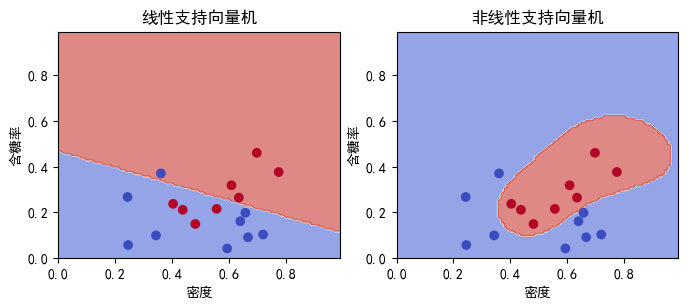

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=(8,3),dpi=100)
title = ['线性支持向量机','非线性支持向量机']
for i,clf in enumerate([clf_linear,clf_rbf]):
    plt.subplot(1,2,i+1)
    xx, yy = np.meshgrid(np.arange(0,1,0.01),np.arange(0,1,0.01))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.array(Z).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.coolwarm)
    plt.xlabel('密度')
    plt.ylabel('含糖率')
    plt.title(title[i])